# Setup

In [ ]:
!pip uninstall tensorflow keras --yes
!pip install tensorflow==2.3

Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
  Using cached https://files.pythonhosted.org/packages/16/89/f2d29c2eafc2eeafb17d5634340e06366af904d332341200a49d954bce85/tensorflow-2.3.0-cp37-cp37m-manylinux2010_x86_64.whl


In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
%%bash
git clone https://github.com/lukewood/spectral-neural-nets && cd spectral-neural-nets && pip install .

Processing /content/spectral-neural-nets
  Created wheel for spectral-neural-nets: filename=spectral_neural_nets-0.0.3-cp37-none-any.whl size=7462 sha256=ad221b4961901f988be76b4bd3b04a422665a2708bf35b813abd2eaeb4b51de9
  Stored in directory: /root/.cache/pip/wheels/c1/2b/22/fc28db8aee6ebf3692ba084a2d86572c33f3f5aa4e95c5e9a7
Successfully built spectral-neural-nets


Cloning into 'spectral-neural-nets'...


In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
(train_data, _), (test_data, _) = mnist.load_data()
train_data = train_data.astype(np.float32)/255.0
test_data = test_data.astype(np.float32)/255.0

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

# Baseline

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def create_model():
  input = layers.Input(shape=(28, 28, 1))
  # Encoder
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)
  x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)

  # Decoder
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
  x = layers.Reshape((28, 28))(x)
  # Autoencoder
  autoencoder = Model(input, x)
  autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
  return autoencoder

In [ ]:
model = create_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)       

In [ ]:
model.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data)
)

Epoch 1/50
469/469 [==============================] - 5s 10ms/step - loss: 0.0676 - val_loss: 0.0669
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0670 - val_loss: 0.0663
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0665 - val_loss: 0.0658
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0661 - val_loss: 0.0655
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0658 - val_loss: 0.0652
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0655 - val_loss: 0.0649
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0653 - val_loss: 0.0647
Epoch 8/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0650 - val_loss: 0.0645
Epoch 9/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0649 - val_loss: 0.0643
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0647 - val_loss: 0.064

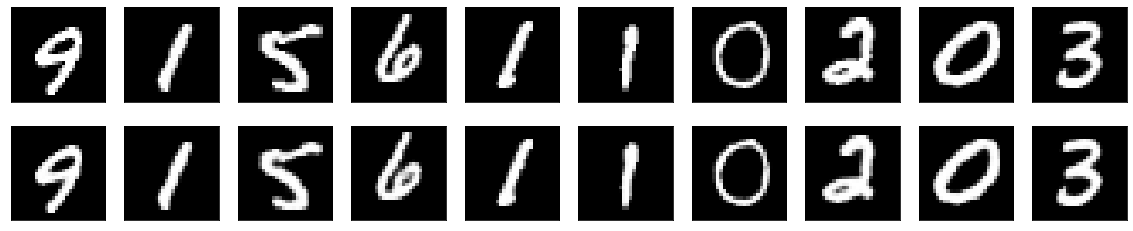

In [ ]:
predictions = model.predict(test_data)
display(test_data, predictions)

# Gaussian Spectral Encoder, Spatial Decoder

In [ ]:
from spectral_neural_nets.layers import Gaussian2DFourierLayer, fft_layer, from_complex, to_complex, ifft_layer
from keras import layers

def spectral_block(x):
  x = fft_layer(x)
  x = from_complex(x)
  x = Gaussian2DFourierLayer(32)(x)
  x = layers.Activation('relu')(x)
  x = to_complex(x)
  x = ifft_layer(x)
  x = layers.MaxPooling2D((2, 2), padding="same")(x)
  return x

def create_spectral_model():
  input = layers.Input(shape=(28, 28))
  x = layers.Reshape((28, 28, 1))(input)

  # Encoder
  x = spectral_block(x)
  x = spectral_block(x)
  # Decoder
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
  x = layers.Reshape((28, 28))(x)
  # Autoencoder
  autoencoder = Model(input, x)
  autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
  return autoencoder

In [ ]:
spectral_autoencoder = create_spectral_model()
spectral_autoencoder.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
fft2d (Lambda)                  multiple             0           reshape_1[0][0]                  
                                                                 max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
from_complex (Lambda)           multiple             0           fft2d[0][0]           

In [ ]:
spectral_autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data)
)

Epoch 1/50
469/469 [==============================] - 36s 76ms/step - loss: 0.2450 - val_loss: 0.1238
Epoch 2/50
469/469 [==============================] - 26s 55ms/step - loss: 0.1136 - val_loss: 0.1050
Epoch 3/50
469/469 [==============================] - 26s 55ms/step - loss: 0.1028 - val_loss: 0.0995
Epoch 4/50
469/469 [==============================] - 26s 55ms/step - loss: 0.0986 - val_loss: 0.0962
Epoch 5/50
469/469 [==============================] - 26s 55ms/step - loss: 0.0962 - val_loss: 0.0942
Epoch 6/50
469/469 [==============================] - 25s 54ms/step - loss: 0.0944 - val_loss: 0.0926
Epoch 7/50
469/469 [==============================] - 26s 55ms/step - loss: 0.0932 - val_loss: 0.0915
Epoch 8/50
469/469 [==============================] - 26s 55ms/step - loss: 0.0921 - val_loss: 0.0906
Epoch 9/50
469/469 [==============================] - 26s 54ms/step - loss: 0.0913 - val_loss: 0.0900
Epoch 10/50
469/469 [==============================] - 26s 55ms/step - loss: 0.090

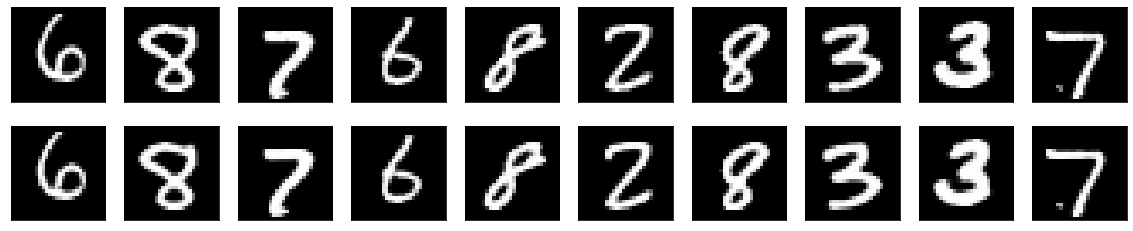

In [ ]:
predictions = model.predict(test_data)
display(test_data, predictions)